# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-24 15:48:37.211207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 15:48:37.820340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 70
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [9]:

train_dataset = load_dataset("../wikitext-2/train.txt")
valid_dataset = load_dataset("../wikitext-2/valid.txt")
test_dataset = load_dataset("../wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1270/1270 [01:52<00:00, 11.28batch/s, loss=6.3, perplexity=915]     


Valid: Loss = 5.303 Perplexity= 210.2, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1270/1270 [01:52<00:00, 11.31batch/s, loss=5.64, perplexity=289]


Valid: Loss = 5.029 Perplexity= 159.2, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1270/1270 [01:53<00:00, 11.16batch/s, loss=5.39, perplexity=225]


Valid: Loss = 4.884 Perplexity= 137.4, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1270/1270 [01:53<00:00, 11.18batch/s, loss=5.22, perplexity=190]


Valid: Loss = 4.796 Perplexity= 125.9, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1270/1270 [01:53<00:00, 11.23batch/s, loss=5.09, perplexity=167]


Valid: Loss = 4.727 Perplexity= 117.6, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1270/1270 [01:52<00:00, 11.34batch/s, loss=4.98, perplexity=150]


Valid: Loss = 4.662 Perplexity= 110.2, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1270/1270 [01:53<00:00, 11.21batch/s, loss=4.89, perplexity=138]


Valid: Loss = 4.621 Perplexity= 105.8, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1270/1270 [01:53<00:00, 11.19batch/s, loss=4.81, perplexity=127]


Valid: Loss = 4.593 Perplexity= 103.0, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1270/1270 [01:53<00:00, 11.15batch/s, loss=4.74, perplexity=119]


Valid: Loss = 4.561 Perplexity= 99.77, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1270/1270 [01:53<00:00, 11.16batch/s, loss=4.67, perplexity=111]


Valid: Loss = 4.548 Perplexity= 98.62, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1270/1270 [01:52<00:00, 11.25batch/s, loss=4.62, perplexity=105]


Valid: Loss = 4.532 Perplexity= 97.07, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1270/1270 [01:51<00:00, 11.38batch/s, loss=4.57, perplexity=100] 


Valid: Loss = 4.529 Perplexity= 96.85, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1270/1270 [01:52<00:00, 11.27batch/s, loss=4.52, perplexity=95.5]


Valid: Loss = 4.516 Perplexity= 95.74, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1270/1270 [01:53<00:00, 11.16batch/s, loss=4.48, perplexity=91.5]


Valid: Loss = 4.507 Perplexity= 94.9, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1270/1270 [01:54<00:00, 11.12batch/s, loss=4.44, perplexity=88.1]


Valid: Loss = 4.498 Perplexity= 94.07, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1270/1270 [01:52<00:00, 11.25batch/s, loss=4.41, perplexity=85.5]


Valid: Loss = 4.501 Perplexity= 94.42, LR = 0.5



Epoch 16: 100%|██████████| 1270/1270 [01:52<00:00, 11.33batch/s, loss=4.31, perplexity=78.1]


Valid: Loss = 4.418 Perplexity= 86.67, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 1270/1270 [01:52<00:00, 11.24batch/s, loss=4.26, perplexity=74]  


Valid: Loss = 4.406 Perplexity= 85.71, LR = 0.25
Model Saved!



Epoch 18: 100%|██████████| 1270/1270 [01:54<00:00, 11.12batch/s, loss=4.23, perplexity=71.7]


Valid: Loss = 4.406 Perplexity= 85.74, LR = 0.25



Epoch 19: 100%|██████████| 1270/1270 [01:54<00:00, 11.12batch/s, loss=4.2, perplexity=69.3] 


Valid: Loss = 4.361 Perplexity= 81.96, LR = 0.125
Model Saved!



Epoch 20: 100%|██████████| 1270/1270 [01:52<00:00, 11.27batch/s, loss=4.16, perplexity=67]  


Valid: Loss = 4.341 Perplexity= 80.23, LR = 0.125
Model Saved!



Epoch 21: 100%|██████████| 1270/1270 [01:52<00:00, 11.31batch/s, loss=4.14, perplexity=65.5]


Valid: Loss = 4.341 Perplexity= 80.34, LR = 0.125



Epoch 22: 100%|██████████| 1270/1270 [01:53<00:00, 11.20batch/s, loss=4.13, perplexity=64.9]


Valid: Loss = 4.301 Perplexity= 77.09, LR = 0.0625
Model Saved!



Epoch 23: 100%|██████████| 1270/1270 [01:54<00:00, 11.11batch/s, loss=4.11, perplexity=63.6]


Valid: Loss = 4.297 Perplexity= 76.74, LR = 0.0625
Model Saved!



Epoch 24: 100%|██████████| 1270/1270 [01:53<00:00, 11.14batch/s, loss=4.09, perplexity=62.7]


Valid: Loss = 4.295 Perplexity= 76.59, LR = 0.0625
Model Saved!



Epoch 25: 100%|██████████| 1270/1270 [01:47<00:00, 11.80batch/s, loss=4.08, perplexity=62]  


Valid: Loss = 4.287 Perplexity= 76.01, LR = 0.0625
Model Saved!



Epoch 26: 100%|██████████| 1270/1270 [01:51<00:00, 11.34batch/s, loss=4.07, perplexity=61.1]


Valid: Loss = 4.288 Perplexity= 76.11, LR = 0.0625



Epoch 27: 100%|██████████| 1270/1270 [01:54<00:00, 11.12batch/s, loss=4.07, perplexity=61.2]


Valid: Loss = 4.26 Perplexity= 74.01, LR = 0.03125
Model Saved!



Epoch 28: 100%|██████████| 1270/1270 [01:53<00:00, 11.17batch/s, loss=4.06, perplexity=60.7]


Valid: Loss = 4.258 Perplexity= 73.83, LR = 0.03125
Model Saved!



Epoch 29: 100%|██████████| 1270/1270 [01:52<00:00, 11.29batch/s, loss=4.05, perplexity=60.2]


Valid: Loss = 4.256 Perplexity= 73.7, LR = 0.03125
Model Saved!



Epoch 30: 100%|██████████| 1270/1270 [01:52<00:00, 11.26batch/s, loss=4.05, perplexity=59.7]


Valid: Loss = 4.255 Perplexity= 73.58, LR = 0.03125
Model Saved!



Epoch 31: 100%|██████████| 1270/1270 [01:53<00:00, 11.15batch/s, loss=4.04, perplexity=59.4]


Valid: Loss = 4.254 Perplexity= 73.57, LR = 0.03125
Model Saved!



Epoch 32: 100%|██████████| 1270/1270 [01:53<00:00, 11.18batch/s, loss=4.03, perplexity=58.9]


Valid: Loss = 4.254 Perplexity= 73.52, LR = 0.03125
Model Saved!



Epoch 33: 100%|██████████| 1270/1270 [01:52<00:00, 11.27batch/s, loss=4.03, perplexity=58.6]


Valid: Loss = 4.251 Perplexity= 73.32, LR = 0.03125
Model Saved!



Epoch 34: 100%|██████████| 1270/1270 [01:52<00:00, 11.29batch/s, loss=4.02, perplexity=58.2]


Valid: Loss = 4.25 Perplexity= 73.26, LR = 0.03125
Model Saved!



Epoch 35: 100%|██████████| 1270/1270 [01:53<00:00, 11.17batch/s, loss=4.01, perplexity=57.9]


Valid: Loss = 4.249 Perplexity= 73.19, LR = 0.03125
Model Saved!



Epoch 36: 100%|██████████| 1270/1270 [01:53<00:00, 11.15batch/s, loss=4.01, perplexity=57.5]


Valid: Loss = 4.247 Perplexity= 73.07, LR = 0.03125
Model Saved!



Epoch 37: 100%|██████████| 1270/1270 [01:52<00:00, 11.25batch/s, loss=4, perplexity=57.2]   


Valid: Loss = 4.247 Perplexity= 73.03, LR = 0.03125
Model Saved!



Epoch 38: 100%|██████████| 1270/1270 [01:52<00:00, 11.29batch/s, loss=4, perplexity=56.9]   


Valid: Loss = 4.246 Perplexity= 72.96, LR = 0.03125
Model Saved!



Epoch 39: 100%|██████████| 1270/1270 [01:53<00:00, 11.17batch/s, loss=3.99, perplexity=56.6]


Valid: Loss = 4.242 Perplexity= 72.71, LR = 0.03125
Model Saved!



Epoch 40: 100%|██████████| 1270/1270 [01:54<00:00, 11.13batch/s, loss=3.99, perplexity=56.4]


Valid: Loss = 4.244 Perplexity= 72.83, LR = 0.03125



Epoch 41: 100%|██████████| 1270/1270 [01:53<00:00, 11.20batch/s, loss=3.99, perplexity=56.4]


Valid: Loss = 4.23 Perplexity= 71.8, LR = 0.015625
Model Saved!



Epoch 42: 100%|██████████| 1270/1270 [01:52<00:00, 11.31batch/s, loss=3.98, perplexity=56.1]


Valid: Loss = 4.229 Perplexity= 71.72, LR = 0.015625
Model Saved!



Epoch 43: 100%|██████████| 1270/1270 [01:52<00:00, 11.26batch/s, loss=3.98, perplexity=56]  


Valid: Loss = 4.226 Perplexity= 71.53, LR = 0.015625
Model Saved!



Epoch 44: 100%|██████████| 1270/1270 [01:53<00:00, 11.15batch/s, loss=3.98, perplexity=55.8]


Valid: Loss = 4.224 Perplexity= 71.38, LR = 0.015625
Model Saved!



Epoch 45: 100%|██████████| 1270/1270 [01:54<00:00, 11.13batch/s, loss=3.98, perplexity=55.6]


Valid: Loss = 4.224 Perplexity= 71.38, LR = 0.015625
Model Saved!



Epoch 46: 100%|██████████| 1270/1270 [01:52<00:00, 11.26batch/s, loss=3.97, perplexity=55.5]


Valid: Loss = 4.225 Perplexity= 71.47, LR = 0.015625



Epoch 47: 100%|██████████| 1270/1270 [01:52<00:00, 11.31batch/s, loss=3.98, perplexity=55.8]


Valid: Loss = 4.218 Perplexity= 70.92, LR = 0.0078125
Model Saved!



Epoch 48: 100%|██████████| 1270/1270 [01:53<00:00, 11.23batch/s, loss=3.98, perplexity=55.8]


Valid: Loss = 4.216 Perplexity= 70.79, LR = 0.0078125
Model Saved!



Epoch 49: 100%|██████████| 1270/1270 [01:54<00:00, 11.12batch/s, loss=3.98, perplexity=55.7]


Valid: Loss = 4.213 Perplexity= 70.61, LR = 0.0078125
Model Saved!



Epoch 50: 100%|██████████| 1270/1270 [01:53<00:00, 11.16batch/s, loss=3.97, perplexity=55.6]


Valid: Loss = 4.212 Perplexity= 70.49, LR = 0.0078125
Model Saved!



Epoch 51: 100%|██████████| 1270/1270 [01:52<00:00, 11.32batch/s, loss=3.97, perplexity=55.4]


Valid: Loss = 4.211 Perplexity= 70.47, LR = 0.0078125
Model Saved!



Epoch 52: 100%|██████████| 1270/1270 [01:52<00:00, 11.30batch/s, loss=3.97, perplexity=55.4]


Valid: Loss = 4.21 Perplexity= 70.37, LR = 0.0078125
Model Saved!



Epoch 53: 100%|██████████| 1270/1270 [01:53<00:00, 11.17batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.209 Perplexity= 70.29, LR = 0.0078125
Model Saved!



Epoch 54: 100%|██████████| 1270/1270 [01:54<00:00, 11.13batch/s, loss=3.97, perplexity=55.2]


Valid: Loss = 4.208 Perplexity= 70.23, LR = 0.0078125
Model Saved!



Epoch 55: 100%|██████████| 1270/1270 [01:53<00:00, 11.21batch/s, loss=3.97, perplexity=55.1]


Valid: Loss = 4.208 Perplexity= 70.25, LR = 0.0078125



Epoch 56: 100%|██████████| 1270/1270 [01:51<00:00, 11.35batch/s, loss=3.97, perplexity=55.5]


Valid: Loss = 4.203 Perplexity= 69.87, LR = 0.00390625
Model Saved!



Epoch 57: 100%|██████████| 1270/1270 [01:52<00:00, 11.25batch/s, loss=3.97, perplexity=55.5]


Valid: Loss = 4.202 Perplexity= 69.78, LR = 0.00390625
Model Saved!



Epoch 58: 100%|██████████| 1270/1270 [01:54<00:00, 11.14batch/s, loss=3.97, perplexity=55.4]


Valid: Loss = 4.201 Perplexity= 69.76, LR = 0.00390625
Model Saved!



Epoch 59: 100%|██████████| 1270/1270 [01:54<00:00, 11.13batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.2 Perplexity= 69.7, LR = 0.00390625
Model Saved!



Epoch 60: 100%|██████████| 1270/1270 [01:52<00:00, 11.34batch/s, loss=3.97, perplexity=55.2]


Valid: Loss = 4.201 Perplexity= 69.72, LR = 0.00390625



Epoch 61: 100%|██████████| 1270/1270 [01:51<00:00, 11.35batch/s, loss=3.97, perplexity=55.6]


Valid: Loss = 4.196 Perplexity= 69.38, LR = 0.001953125
Model Saved!



Epoch 62: 100%|██████████| 1270/1270 [01:52<00:00, 11.33batch/s, loss=3.97, perplexity=55.5]


Valid: Loss = 4.195 Perplexity= 69.35, LR = 0.001953125
Model Saved!



Epoch 63: 100%|██████████| 1270/1270 [01:43<00:00, 12.32batch/s, loss=3.97, perplexity=55.5]


Valid: Loss = 4.195 Perplexity= 69.29, LR = 0.001953125
Model Saved!



Epoch 64: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.97, perplexity=55.4]


Valid: Loss = 4.194 Perplexity= 69.28, LR = 0.001953125
Model Saved!



Epoch 65: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.194 Perplexity= 69.24, LR = 0.001953125
Model Saved!



Epoch 66: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.97, perplexity=55.4]


Valid: Loss = 4.193 Perplexity= 69.2, LR = 0.001953125
Model Saved!



Epoch 67: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.193 Perplexity= 69.21, LR = 0.001953125



Epoch 68: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.97, perplexity=55.4]


Valid: Loss = 4.192 Perplexity= 69.07, LR = 0.0009765625
Model Saved!



Epoch 69: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.191 Perplexity= 69.03, LR = 0.0009765625
Model Saved!



Epoch 70: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.191 Perplexity= 69.02, LR = 0.0009765625
Model Saved!



Epoch 71: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.3]


Valid: Loss = 4.191 Perplexity= 69.02, LR = 0.0009765625
Model Saved!



Epoch 72: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.97, perplexity=55.2]


Valid: Loss = 4.19 Perplexity= 69.0, LR = 0.0009765625
Model Saved!



Epoch 73: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.2]


Valid: Loss = 4.19 Perplexity= 68.99, LR = 0.0009765625
Model Saved!



Epoch 74: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.1]


Valid: Loss = 4.19 Perplexity= 68.97, LR = 0.0009765625
Model Saved!



Epoch 75: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.97, perplexity=55.1]


Valid: Loss = 4.19 Perplexity= 68.97, LR = 0.0009765625
Model Saved!



Epoch 76: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=55.1]


Valid: Loss = 4.19 Perplexity= 68.96, LR = 0.0009765625
Model Saved!



Epoch 77: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=55.1]


Valid: Loss = 4.19 Perplexity= 68.94, LR = 0.0009765625
Model Saved!



Epoch 78: 100%|██████████| 1270/1270 [01:43<00:00, 12.32batch/s, loss=3.96, perplexity=55.1]


Valid: Loss = 4.19 Perplexity= 68.96, LR = 0.0009765625



Epoch 79: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=55.1]


Valid: Loss = 4.189 Perplexity= 68.91, LR = 0.00048828125
Model Saved!



Epoch 80: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55.1]


Valid: Loss = 4.189 Perplexity= 68.89, LR = 0.00048828125
Model Saved!



Epoch 81: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55.1]


Valid: Loss = 4.189 Perplexity= 68.88, LR = 0.00048828125
Model Saved!



Epoch 82: 100%|██████████| 1270/1270 [01:43<00:00, 12.32batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.189 Perplexity= 68.86, LR = 0.00048828125
Model Saved!



Epoch 83: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.86, LR = 0.00048828125
Model Saved!



Epoch 84: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.85, LR = 0.00048828125
Model Saved!



Epoch 85: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.188 Perplexity= 68.86, LR = 0.00048828125



Epoch 86: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.83, LR = 0.000244140625
Model Saved!



Epoch 87: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.82, LR = 0.000244140625
Model Saved!



Epoch 88: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.82, LR = 0.000244140625
Model Saved!



Epoch 89: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.81, LR = 0.000244140625
Model Saved!



Epoch 90: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.188 Perplexity= 68.81, LR = 0.000244140625
Model Saved!



Epoch 91: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.8, LR = 0.000244140625
Model Saved!



Epoch 92: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.188 Perplexity= 68.81, LR = 0.000244140625



Epoch 93: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.78, LR = 0.0001220703125
Model Saved!



Epoch 94: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.78, LR = 0.0001220703125
Model Saved!



Epoch 95: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.78, LR = 0.0001220703125
Model Saved!



Epoch 96: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.78, LR = 0.0001220703125



Epoch 97: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.77, LR = 6.103515625e-05
Model Saved!



Epoch 98: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.77, LR = 6.103515625e-05
Model Saved!



Epoch 99: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.77, LR = 6.103515625e-05
Model Saved!



Epoch 100: 100%|██████████| 1270/1270 [01:43<00:00, 12.32batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 6.103515625e-05
Model Saved!



Epoch 101: 100%|██████████| 1270/1270 [01:43<00:00, 12.28batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 6.103515625e-05
Model Saved!



Epoch 102: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 6.103515625e-05



Epoch 103: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05
Model Saved!



Epoch 104: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05
Model Saved!



Epoch 105: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.8]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05
Model Saved!



Epoch 106: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.8]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05
Model Saved!



Epoch 107: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05
Model Saved!



Epoch 108: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05
Model Saved!



Epoch 109: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 3.0517578125e-05



Epoch 110: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.76, LR = 1.52587890625e-05
Model Saved!



Epoch 111: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 1.52587890625e-05
Model Saved!



Epoch 112: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 1.52587890625e-05
Model Saved!



Epoch 113: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 1.52587890625e-05
Model Saved!



Epoch 114: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 1.52587890625e-05
Model Saved!



Epoch 115: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 1.52587890625e-05



Epoch 116: 100%|██████████| 1270/1270 [01:43<00:00, 12.29batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 7.62939453125e-06
Model Saved!



Epoch 117: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 7.62939453125e-06
Model Saved!



Epoch 118: 100%|██████████| 1270/1270 [01:43<00:00, 12.28batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 7.62939453125e-06



Epoch 119: 100%|██████████| 1270/1270 [01:43<00:00, 12.30batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 3.814697265625e-06
Model Saved!



Epoch 120: 100%|██████████| 1270/1270 [01:43<00:00, 12.31batch/s, loss=3.96, perplexity=54.8]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 3.814697265625e-06
Model Saved!



Epoch 121: 100%|██████████| 1270/1270 [01:44<00:00, 12.14batch/s, loss=3.96, perplexity=54.9]


Valid: Loss = 4.187 Perplexity= 68.75, LR = 3.814697265625e-06
Model Saved!



Epoch 122:   8%|▊         | 102/1270 [00:09<01:46, 11.01batch/s, loss=4.01, perplexity=57.3]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4                                                                                             │
│    5 for epoch in range(num_epochs):                                                             │
│    6   # Train                                                                                   │
│ ❱  7   model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer    │
│    8   # Validation                                                                              │
│    9   loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)                        │
│   10                                                                                             │
│                                                                                                  │
│ in train_one_epoch:28                                                                            │
│                                                                                                  │
│   25 │                                                                                           │
│   26 │     loss.backward()                                                                       │
│   27 │                                                                                           │
│ ❱ 28 │     perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batc    │
│   29 │                                                                                           │
│   30 │     optimizer.step()                                                                      │
│   31 │     optimizer.zero_grad()                                                                 │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torchmetrics/metric.py:298 in forward          │
│                                                                                                  │
│    295 │   │   if self.full_state_update or self.full_state_update is None or self.dist_sync_on  │
│    296 │   │   │   self._forward_cache = self._forward_full_state_update(*args, **kwargs)        │
│    297 │   │   else:                                                                             │
│ ❱  298 │   │   │   self._forward_cache = self._forward_reduce_state_update(*args, **kwargs)      │
│    299 │   │                                                                                     │
│    300 │   │   return self._forward_cache                                                        │
│    301                                                     

## Learning Curve

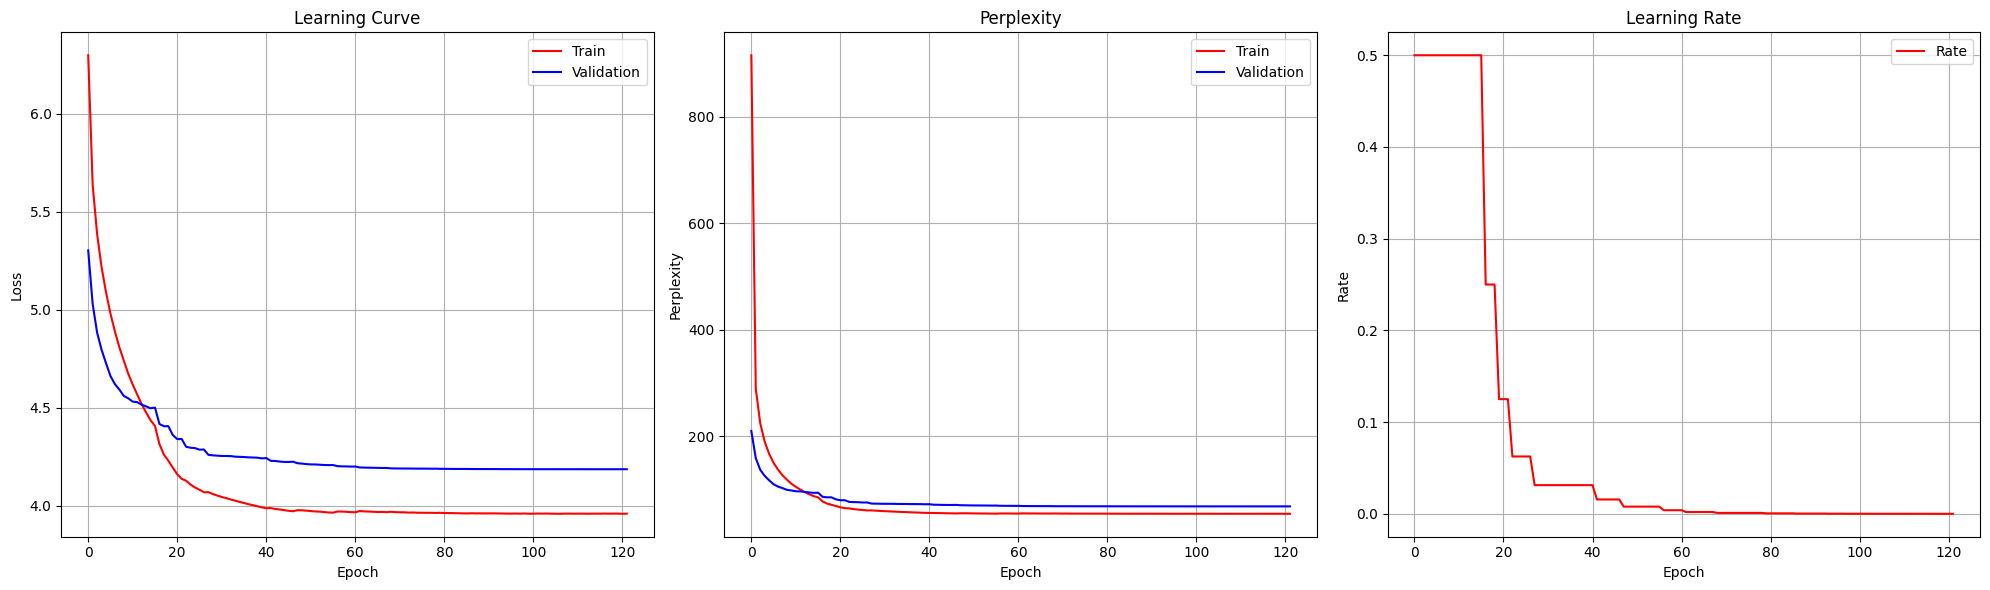

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 4.187 , Perplexity = 68.75
Test: Loss = 4.076 , Perplexity = 63.34


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [50]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>"]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.9, 
                          model = model)

print(generated_text)

i think the movie represents the Tempest . = = = &lt; unk &gt; = = = The fourth pair of Venus on the top 32 faces are preserved without the other immense level . The low @ - @ neck technique reduces the high 240 @ - @ wing chains , measuring 25 @ , @ 000 metres ( 1 @ , @ 117 ft ) in length , with a jurisdiction in the 4th Scouts and lower feet over the back . The straight length , where the secondary pectoral is an intruder , light @ - @ side , and with
